In [1]:
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
with open("/content/drive/MyDrive/Colab Notebooks/type_pred_desc_data.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")


First line (header) looks like this:

"category","text"

Each data point looks like this:

PHARMACY,খরচ বিকাশে হাওলাত



In [3]:
NUM_WORDS = 500000
EMBEDDING_DIM = 16
MAXLEN = 20
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .85

In [4]:
def remove_stopwords(sentence):
    """
    Removes a list of stopwords
    
    Args:
        sentence (string): sentence to remove the stopwords from
    
    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    pass

    return sentence


def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file
    
    Args:
        filename (string): path to the CSV file
    
    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, labels

In [5]:
# Test the functions
sentences, labels = parse_data_from_file("/content/drive/MyDrive/Colab Notebooks/type_pred_desc_data.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 21531 sentences in the dataset.

First sentence has 3 words (after removing stopwords).

There are 21531 labels in the dataset.

The first 5 labels are ['PHARMACY', 'MFSMOBILERECHARGE', 'PHARMACY', 'GROCERY', 'GROCERY']


In [6]:
# GRADED FUNCTIONS: train_val_split
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets
    
    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set
    
    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """
    
    ### START CODE HERE
    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = round(len(sentences)*training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[0:train_size]
    train_labels = labels[0:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    ### END CODE HERE
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [7]:
# Test your function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 18301 sentences for training.

There are 18301 labels for training.

There are 3230 sentences for validation.

There are 3230 labels for validation.


In [8]:
# GRADED FUNCTION: fit_tokenizer
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token
    
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    
    ### START CODE HERE
    
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words = num_words, oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    ### END CODE HERE
    
    return tokenizer

In [9]:
# Test your function
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 33855 words

<OOV> token included in vocabulary


In [10]:
# GRADED FUNCTION: seq_and_pad
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """    
    ### START CODE HERE
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)
    
    ### END CODE HERE
    
    return padded_sequences

In [11]:
# Test your function
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (18301, 20)

Padded validation sequences have shape: (3230, 20)


In [12]:
# categories into numerics
categories=list()

In [13]:
# GRADED FUNCTION: tokenize_labels
def tokenize_labels(all_labels, split_labels):
    """
    Tokenizes the labels
    
    Args:
        all_labels (list of string): labels to generate the word-index from
        split_labels (list of string): labels to tokenize
    
    Returns:
        label_seq_np (array of int): tokenized labels
    """
    ### START CODE HERE
    
    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()
    
    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)

    global categories
    categories = list(label_tokenizer.word_index)
    
    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels) 
    
    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    label_seq_np = np.array(label_seq)-1
    
    ### END CODE HERE
    
    return label_seq_np

In [14]:
# Test your function
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print("Labels are: ", categories)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

Labels are:  ['grocery', 'mfsmobilerecharge', 'pharmacy', 'electronics', 'clothstore', 'hardware', 'stationery']
First 5 labels of the training set should look like this:
[[2]
 [1]
 [2]
 [0]
 [0]]

First 5 labels of the validation set should look like this:
[[3]
 [1]
 [1]
 [4]
 [1]]

Tokenized labels of the training set have shape: (18301, 1)

Tokenized labels of the validation set have shape: (3230, 1)



In [15]:
# GRADED FUNCTION: create_model
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    ### END CODE HERE

    return model


In [16]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=10, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/10
572/572 [==============================] - 23s 39ms/step - loss: 1.5265 - accuracy: 0.4407 - val_loss: 1.2377 - val_accuracy: 0.5610
Epoch 2/10
572/572 [==============================] - 21s 37ms/step - loss: 1.2001 - accuracy: 0.5841 - val_loss: 1.1074 - val_accuracy: 0.6115
Epoch 3/10
572/572 [==============================] - 21s 36ms/step - loss: 1.0590 - accuracy: 0.6367 - val_loss: 1.0749 - val_accuracy: 0.6183
Epoch 4/10
572/572 [==============================] - 21s 37ms/step - loss: 0.9634 - accuracy: 0.6749 - val_loss: 1.0547 - val_accuracy: 0.6365
Epoch 5/10
572/572 [==============================] - 21s 36ms/step - loss: 0.8842 - accuracy: 0.7026 - val_loss: 1.0596 - val_accuracy: 0.6347
Epoch 6/10
572/572 [==============================] - 21s 36ms/step - loss: 0.8128 - accuracy: 0.7296 - val_loss: 1.0841 - val_accuracy: 0.6337
Epoch 7/10
572/572 [==============================] - 21s 37ms/step - loss: 0.7488 - accuracy: 0.7519 - val_loss: 1.1060 - val_accuracy:

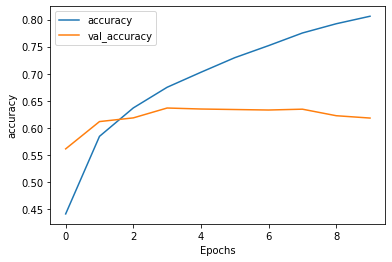

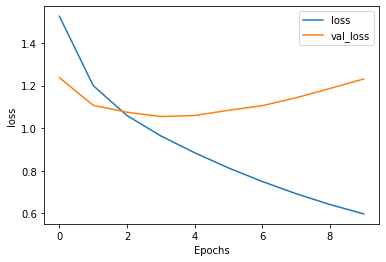

In [17]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [18]:
# probabilies against all classes for selective validation data
pred_probabilities=model.predict(val_padded_seq[0:100, :])

# predictions against selective validation data
pred_classes=[categories[item] for item in np.argmax(pred_probabilities, axis=1)]
val_shop_names=val_sentences[0:100]

for i in range(0, len(val_shop_names)): 
  print(val_shop_names[i]+ ": "+pred_classes[i])

print()

# if predictions match
print(np.argmax(pred_probabilities, axis=1)==(np.squeeze(val_label_seq[0:100])))

4/4 [==============================] - 0s 2ms/step
কেপাসিটার চাজার কট চানাচুর বিসকুট চা পান পাউরুটি রেগুলিটার: grocery
খরজা জমা জযা তালা দেওয়া নাজমুল ভাইয়ের মজা বিকাশ বিয়ার সালাম মজা: electronics
ইমরান জমা জমা রিচার্জ: pharmacy
এঙ্গেল মেস্তেরী সুমন ভাই এসি কারেন্ট এর মেস্তেরী গাড়ি ভাড়া থাই গ্লাস লাগানো থাই মেস্তেরী নাস্তা বোড মেস্তেরী রং রং মেস্তেরী: electronics
 এমবি পেল পেলাম পেল্ম প্লম মিনিট র লাভ সাড়ে চার হাজার টাকা আনছে পাচশো টাকাখরচ দিয়া নিয়ে গেছে: electronics
কয়েল কাটুন বিস্কুট খাতা চকলেট চাউল চাউল তেল চানাচুর মুড়ি চাল তেল বিরাশ বিস্কুট চিনি চিনি সাবান ছেলে জুশ টাইগার তেল তৈল তোমার বাবা দুধ বাজার বাজার শুভ বিস্কুট ভুষি ভুষি বাজার মুড়ি চানাচুর জুশ লবণ সাবান সাবানের গুড়া স্নু হাওলাত: grocery
কোড়া চাল পিট ফিট ভূষ ভূষি মশরি সোবারি: grocery
লাইট লোড: mfsmobilerecharge
চয়েস বিস্কিট টাকা কাজের বোয়া সময় সকাল রিংকু: grocery
মিনিট: mfsmobilerecharge
কেজি চা গ্ৰাম চা জমা বাকি: grocery
কত দিন কারেন্ট বিল তবে একটু শব্দে দেখো তোমার কত টাকা বাকি তাহলে আমার ব্যবসা বাণিজ্য কিছু আছে আর 